# Interfacing nDspec with Xspec models

This tutorial shows how to use call Xspec models in Python using nDspec. This functionality allows users to call *any* Fortran or C model in Python, as long as the function and format are compatible with Xspec models.

In [1]:
import sys
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec

from matplotlib import rc, rcParams
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern']})
fi = 22
plt.rcParams.update({'font.size': fi-5})

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from ndspec.Response import ResponseMatrix
import ndspec.XspecInterface as XSModels

## Loading the Xspec library and initializing models

The Xspec models are all compiled in a library file contained at ```path\_to\_heasoft\_installation/Xspec/platform\_name/lib/``` called ```libXSFunctions.so``` (on Linux systems) and ```lib.XSFunctions.dylib``` (on MacOS). The class ```FortranInterface``` automatically finds this file and runs the necessary HEASOFT-related setup when one of its object is initialized. After a couple more initialization steps, we will be able to use this class to run the Fortran wrappers which call any model compiled in our library file.

In [2]:
model_library = XSModels.FortranInterface()

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


We can now define a set of dummy functions, named identically to any Xspec model we might want to use. We will then use these functions to tell ```model_liberary``` which models to make available for use. We can either initialize one model at a time with the ```add_model``` method, or pass a dictionary of models we might want with the ```load_models``` method. In this case, we will use a set of models one might use to run a simple fit of an accreting black hole, including a disk (```diskbb```), a Comptonized component (```nthcomp```), line of sight absorption (```tbabs```) and a simple reflection model (```reflect```):

In [3]:
def tbabs(ear, params):
    pass

def diskbb(ear, params):
    pass

def nthcomp(ear, params):
    pass

def reflect(ear,params,seed):
    pass

model_library.load_models({
    "diskbb": diskbb,
    "tbabs": tbabs,
    "nthcomp": nthcomp
})

model_library.add_model(reflect)

<function __main__.reflect(ear, params, seed)>

We can now print the models we initialized, together with their parameters and the model type, using the ```print_model_info``` method:

In [4]:
model_library.print_model_info()


Initialized Xspec models:
diskbb:
  type: add
  function called: xsdskb
  parameters:
    Tin: value: 1.0, min: 0.0, max: 1000.0, unit: keV
    norm: value: 1, min: 0, max: 1e+20, unit: n/a

tbabs:
  type: mul
  function called: C_tbabs
  parameters:
    nH: value: 1.0, min: 0.0, max: 1000000.0, unit: 10^22

nthcomp:
  type: add
  function called: C_nthcomp
  parameters:
    Gamma: value: 1.7, min: 1.001, max: 10.0, unit: n/a
    kT_e: value: 100.0, min: 1.0, max: 1000.0, unit: keV
    kT_bb: value: 0.1, min: 0.001, max: 10.0, unit: keV
    inp_type: value: 0.0, min: 0.0, max: 1.0, unit: 0/1
    Redshift: value: 0.0, min: -0.999, max: 10.0, unit: n/a
    norm: value: 1, min: 0, max: 1e+20, unit: n/a

reflect:
  type: con
  function called: C_reflct
  parameters:
    rel_refl: value: 0.0, min: -1.0, max: 1000000.0, unit: n/a
    Redshift: value: 0.0, min: -0.999, max: 10.0, unit: n/a
    abund: value: 1.0, min: 0.0, max: 1000000.0, unit: n/a
    Fe_abund: value: 1.0, min: 0.0, max: 100

## Evaluating and plotting additive and multiplicative models

In order to evaluate models, we now need to define a grid of photon energies. Let us define our energy grid from the NICER instrument response. 

IMPORTANT: because our models come from Xspec and follow its standard formatting, what we need to pass is a grid of all *energy bin edges*, rather than mid points of each energy bin. We can do this simply by appending the last element of the ```energ_hi``` array (which contains the upper bound of each energy bin in the matrix) to the entire ```energ_lo``` array (which contains all the lower bounds of the same grid).

In [5]:
rmfpath = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
nicer_matrix = ResponseMatrix(rmfpath)

energs = np.append(nicer_matrix.energ_lo,nicer_matrix.energ_hi[-1])

Arf missing, please load it


Now all that we need to do to evaluate one of our models is to define the appropriate arrays of parameters. Once these are defined, we can call our model functions directly from the library, which now contains a method for each of the models initialized above, with the appropriate name:

Text(0, 0.5, 'Counts/s')

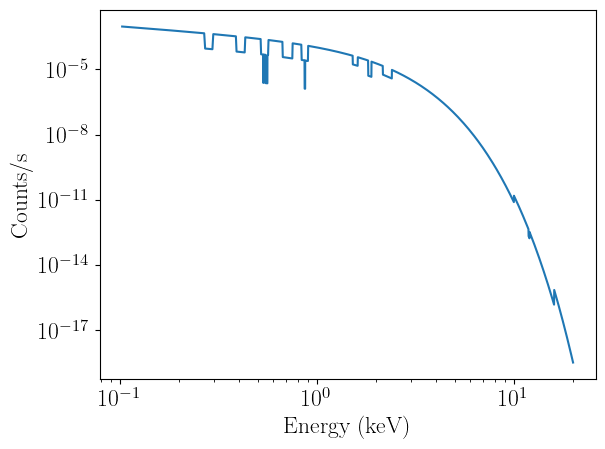

In [6]:
#define the parameters
Tin = 0.5
disknorm = 50
diskpars = np.array([Tin,disknorm])

#now call one of the models and plot it
midpoint = 0.5*(energs[1:]+energs[:-1])

disk = model_library.diskbb(energs,diskpars)

plt.loglog(midpoint,disk)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts/s")

Note that there are numerous discrete jumps and edges in the ```disk``` array. This is because Xspec models all return arrays that need to be renormalized by the bin width:

Text(0, 0.5, 'Counts/s/keV')

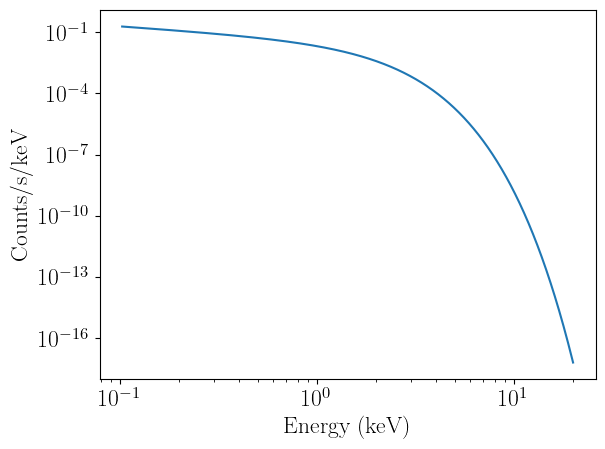

In [7]:
binwidth = nicer_matrix.energ_hi - nicer_matrix.energ_lo

plt.loglog(midpoint,disk/binwidth)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts/s/keV")

Now that we have corrected the units of our models, let us include two more components:

(0.0015, 0.05)

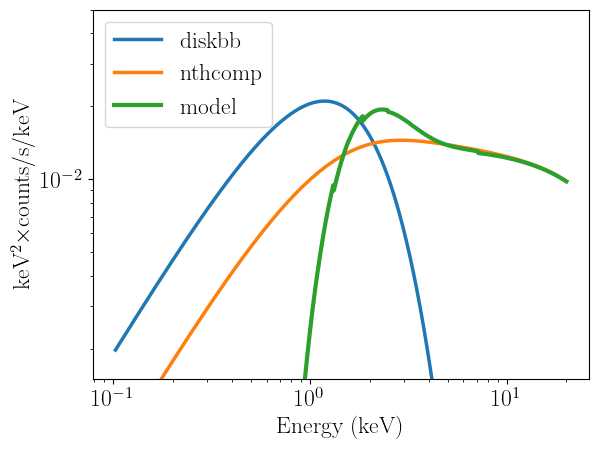

In [8]:
nH = 1
abspars = np.array([nH])

Gamma = 2.1
kT_e = 10.
kT_bb = Tin
inp_type = 1
Redshift = 0
compnorm = 0.01
nthcomppars = np.array([Gamma,kT_e,kT_bb,inp_type,Redshift,compnorm])

absorption = model_library.tbabs(energs,abspars)
compton = model_library.nthcomp(energs,nthcomppars)

model = absorption*(compton+disk)

#let us also convert the y axis to flux
plt.loglog(midpoint,disk/binwidth*midpoint**2,label="diskbb",lw=2.5)
plt.loglog(midpoint,compton/binwidth*midpoint**2,label="nthcomp",lw=2.5)
plt.loglog(midpoint,model/binwidth*midpoint**2,label="model",lw=3)
plt.xlabel("Energy (keV)")
plt.ylabel("keV$^{2}\\times$counts/s/keV")
plt.legend(loc="upper left")
plt.ylim([1.5e-3,0.05])

## Handling convolution models

Finally, we can try to include a convolution model like ```reflect```. This case is more complex, for two reasons. First,we also need to provide the starting array to be convolved with the model. Second, in order to avoid numerical issues (particularly near the bondary of the energy grid), we actually need to use a wider energy grid, and then interpolate back to the NICER grid after performing the convolution. We will use ```scipy``` for this. 

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.
Compton reflection. See help for details.
If you use results of this model in a paper,
please refer to Magdziarz & Zdziarski 1995 MNRAS, 273, 837


(0.0015, 0.05)

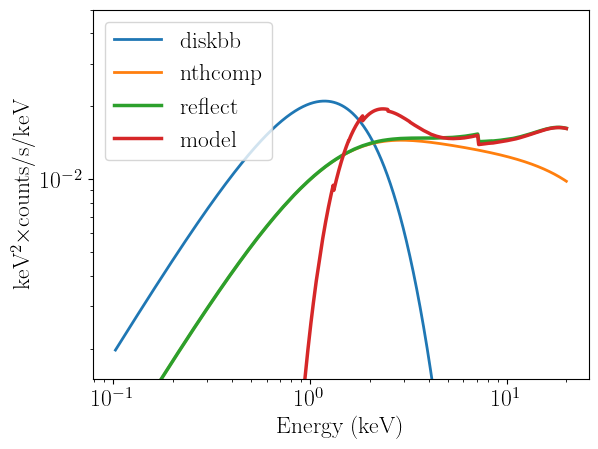

In [9]:
from scipy.interpolate import interp1d

energs_extend = np.logspace(-2.,3,1000)
energs_extend = np.array(energs_extend)
binwidth_extend = np.diff(energs_extend)
compton_extend = model_library.nthcomp(energs_extend,nthcomppars)

rel_refl = 1
Redshift = 0
abund = 1
Fe_abund = 1
cosIncl = 1

refpars = np.array([rel_refl,Redshift,abund,Fe_abund,cosIncl])

#here we must renormalize by the binwidth to make the interpolation below possible
reflection_extend = model_library.reflect(energs_extend,refpars,compton_extend)/binwidth_extend

#now define an interpolation object and go back to the NICER energy grid
energs_extend_center = 0.5*(energs_extend[1:]+energs_extend[:-1])
array_interp = interp1d(energs_extend_center,reflection_extend,fill_value='extrapolate')        
reflection = array_interp(midpoint)

#finally, put all the model components together
model = absorption*(reflection+disk/binwidth)

plt.loglog(midpoint,disk/binwidth*midpoint**2,label="diskbb",lw=2)
plt.loglog(midpoint,compton/binwidth*midpoint**2,label="nthcomp",lw=2)
plt.loglog(midpoint,reflection*midpoint**2,label="reflect",lw=2.5)
plt.loglog(midpoint,model*midpoint**2,label="model",lw=2.5)
plt.xlabel("Energy (keV)")
plt.ylabel("keV$^{2}\\times$counts/s/keV")
plt.legend(loc="upper left")
plt.ylim([1.5e-3,0.05])

## User-defined C models

Users can also load user-defined libraries and models other than those built by a HEASOFT installation, provided that they use the same input and output format. In this example, we will use the ```CInterface``` class to initialize and run the [Relxill](https://www.sternwarte.uni-erlangen.de/~dauser/research/relxill) reflection model. In this case, users always need to specify both the path to the library they want to load, as well as that to the corresponding ```lmodel.dat``` file containing the model definitions and parameters.

In [10]:
#define the path to the libraries and lmodel file to be loaded
relxillpath = '/home/matteo/Software/Relxill/librelxill.so'
relxillfile = '/home/matteo/Software/Relxill/lmodel_relxill.dat'

custom_library = XSModels.CInterface(relxillpath,relxillfile)

def relxill(ear, params):
    pass
    
custom_library.add_model(relxill)
custom_library.print_model_info()


Initialized Xspec models:
relxill:
  type: add
  function called: c_lmodrelxill
  parameters:
    Index1: value: 3.0, min: -10.0, max: 10.0, unit: 
    Index2: value: 3.0, min: -10.0, max: 10.0, unit: 
    Rbr: value: 15.0, min: 1.0, max: 1000.0, unit: 
    a: value: 0.998, min: -0.998, max: 0.998, unit: 
    Incl: value: 30.0, min: 3.0, max: 87.0, unit: deg
    Rin: value: -1.0, min: -100.0, max: -1.0, unit: 
    Rout: value: 400.0, min: 1.0, max: 1000.0, unit: 
    z: value: 0.0, min: 0.0, max: 10.0, unit: 
    gamma: value: 2.0, min: 1.0, max: 3.4, unit: 
    logxi: value: 3.1, min: 0.0, max: 4.7, unit: 
    Afe: value: 1.0, min: 0.5, max: 10.0, unit: 
    Ecut: value: 300.0, min: 5.0, max: 1000.0, unit: keV
    refl_frac: value: 3.0, min: -1000.0, max: 1000.0, unit: 
    norm: value: 1, min: 0, max: 1e+20, unit: n/a



We can now define a set of parameters and evaluate the model identically to before:

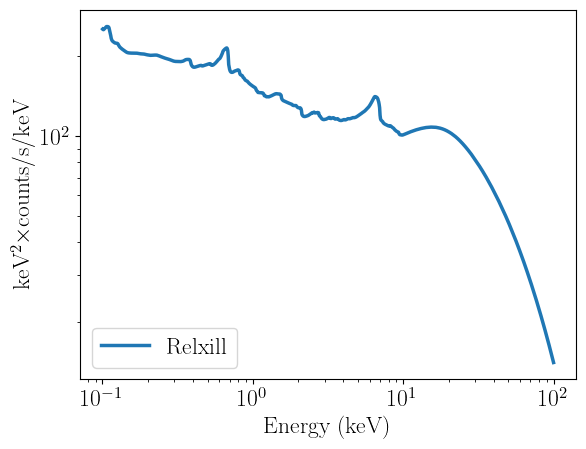

In [11]:
Index1 = 3
Index2 = 3
Rbr = 15
a = 0.998
incl = 30
Rin = -5
Rout = 400
z = 0
gamma = 2
logxi = 3
Afe = 1
Ecut = 50
refl_frac = 1
norm = 1

params_relxill = np.array([Index1,Index2,Rbr,a,incl,Rin,Rout,z,gamma,logxi,Afe,Ecut,refl_frac,norm])

energs = np.logspace(-1.,2,1000)
binwidth = np.diff(energs)
midpoint = 0.5*(energs[1:]+energs[:-1])

relxill_flux = custom_library.relxill(energs,params_relxill)

plt.figure(1)
plt.loglog(midpoint,relxill_flux/binwidth*midpoint**2,lw=2.5,label="Relxill")
plt.xlabel("Energy (keV)")
plt.ylabel("keV$^{2}\\times$counts/s/keV")
plt.legend(loc="lower left")